The following notebook will cover library enumeration using a chemical language model (CLM) adapated from quasi-biogenic molecule generator with deep recurrent neural network - [QBMG](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0328-9). The following will consist of a prior model pre-trained on ZINC biogenic molecules to gain an understanding of molecular string syntax and molecular bioactivity, we can then fine-tune it to generate molecules within our chemical space of interest.



In [1]:
#Unzip QBMG.zip file

from zipfile import ZipFile

# Path to the zip file
zip_file_path = '/content/QBMG.zip'

# Unzip the file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('')


In [ ]:
#Install dependencies

!pip install torch rdkit tqdm matplotlib umap-learn


In [3]:
#From our scaffold set of SMARTS codes, we need to replace wildcards (*) with hydrogens

from rdkit import Chem

def replace_wildcards_with_hydrogens(smarts_code):
    return smarts_code.replace('*', '[H]')

def smarts_to_canonical_smiles(smarts_code):
    updated_smarts = replace_wildcards_with_hydrogens(smarts_code)
    mol = Chem.MolFromSmarts(updated_smarts)  # Convert SMARTS to RDKit molecule
    if mol is None:
        return None  # Invalid SMARTS, skip
    # Convert to canonical SMILES and remove explicit hydrogens
    canonical_smiles = Chem.MolToSmiles(mol, canonical=True)
    return canonical_smiles

def process_smarts_file(input_file, output_file):
    total_smarts = 0
    invalid_smarts_count = 0

    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            smarts_code = line.strip()  # Remove leading/trailing whitespace
            canonical_smiles = smarts_to_canonical_smiles(smarts_code)
            if canonical_smiles:  # Only write valid SMILES
                outfile.write(canonical_smiles + '\n')

# Modify file paths here
input_file = '/content/scaffolds random.smi'   # Replace with the path to your input file
output_file = '/content/scaffolds_converted.smi' # Path for the output file

process_smarts_file(input_file, output_file)

In [ ]:
##Use pretrained model, zinc_biogenic library. Fine-tune on scaffold randoms. This will converge pretty
#quickly, so you can stop training early

!python3 /content/QBMG/transfer_learning.py /content/scaffolds_converted.smi




In [ ]:
#Now we can sample a 10k (adjust number below to increase or decrease) molecules with our fine-tuned model. Increase the temperature parameter in the
#sample.py file to increase diversity (default is 1, but currently set at 1.5)

!python3 /content/QBMG/sample.py /content/QBMG/data/100_epochs_transfer.ckpt 10000

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


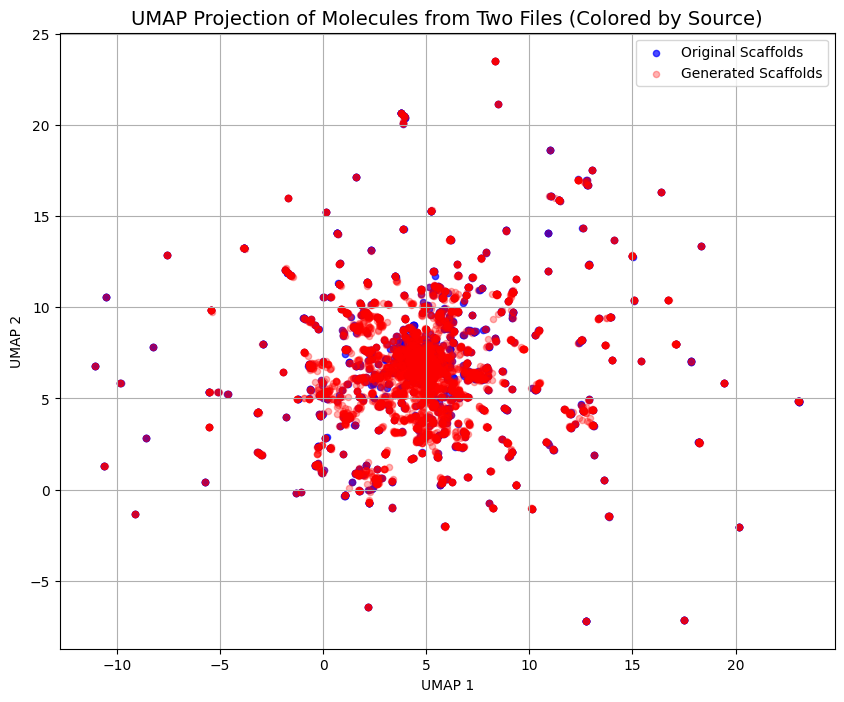

In [7]:
#Lets visualize the chemical space of the generated molecules relative to the original molecules

import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem
import umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

RDLogger.DisableLog("rdApp.*")

# Function to read SMILES from a text file
def read_smiles(file):
    with open(file, 'r') as f:
        smiles_list = [line.strip() for line in f.readlines()]
    return smiles_list

# Function to calculate Morgan fingerprints (radius 2, 1024 bits)
def calculate_fingerprints(smiles_list):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024) for mol in mols if mol]
    return fingerprints

# Read SMILES from two separate files
file1 = '/content/scaffolds_converted.smi'  # Adjust the file paths
file2 = '/content/sample.smi'

smiles_file1 = read_smiles(file1)
smiles_file2 = read_smiles(file2)

# Calculate Morgan fingerprints for each file
fps_file1 = calculate_fingerprints(smiles_file1)
fps_file2 = calculate_fingerprints(smiles_file2)

# Combine fingerprints into one dataset
fps_combined = fps_file1 + fps_file2

# Convert fingerprints to numpy array
fps_array = np.array([list(fp) for fp in fps_combined])

# Apply standard scaling before UMAP
scaler = StandardScaler()
fps_scaled = scaler.fit_transform(fps_array)

# Perform UMAP dimensionality reduction
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
embedding = umap_model.fit_transform(fps_scaled)

# Separate UMAP embeddings for file1 and file2
embedding_file1 = embedding[:len(fps_file1)]
embedding_file2 = embedding[len(fps_file1):]

# Plot UMAP result with different alpha values for file1 (blue) and file2 (red)
plt.figure(figsize=(10, 8))

# Plot molecules from file1 (blue, more opaque)
plt.scatter(embedding_file1[:, 0], embedding_file1[:, 1], c='blue', alpha=0.7, s=20, label='Original Scaffolds')

# Plot molecules from file2 (red, more transparent)
plt.scatter(embedding_file2[:, 0], embedding_file2[:, 1], c='red', alpha=0.3, s=20, label='Generated Scaffolds')

# Plot settings
plt.title('UMAP Projection of Molecules from Two Files (Colored by Source)', fontsize=14)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.grid(True)
plt.show()